# COVID-19 Prediction of high risk of Fatality

Jiajie Xu, 10Jan2022

# Overview

## Business Problem

It's been two years, but countries around the world are still suffering from the Covid-19 and its varients. We are losing people's life every second. The best way to protect them is vaccination, but the vaccine supply is also influenced by the pandemic. We have got a very urgent priorites to thrash out, which is predicttion of a higher-risk population by using current patient group survey dataset. Thus, we would be able to slow down the death and spread. 

# Data Loading and cleaning

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.7.0
Default GPU Device: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.datasets import load_iris
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [3]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is C649-A6AD

 Directory of d:\Flatiron\Project3

01/10/2022  04:53 AM    <DIR>          .
12/11/2021  05:55 PM    <DIR>          ..
12/19/2021  03:34 PM    <DIR>          .ipynb_checkpoints
12/11/2021  05:56 PM        46,684,628 covid.csv
01/10/2022  12:25 AM    <DIR>          tensorflow-gpu-tutorial
01/10/2022  04:53 AM           217,978 Untitled1.ipynb
               2 File(s)     46,902,606 bytes
               4 Dir(s)  1,564,211,036,160 bytes free


In [4]:
df = pd.read_csv('covid.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [6]:
# for c in df.columns:
#     print ("---- %s ---" % c)
#     print (df[c].value_counts())
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


## entry_date	date_symptoms	date_died

In [7]:
df['date_symptoms'] = pd.to_datetime(df['date_symptoms'], format='%d-%m-%Y')
df['entry_date'] = pd.to_datetime(df['entry_date'], format='%d-%m-%Y')
df['date_Difference'] = (df['entry_date'] - df['date_symptoms']).dt.days

In [8]:
df.loc[df['date_died'] == '9999-99-99', 'date_died'] = 0

In [9]:
df.loc[df['date_died'] != 0, 'date_died'] = 1

In [10]:
df['date_died'].value_counts(normalize = True)

0    0.936153
1    0.063847
Name: date_died, dtype: float64

In [11]:
df = df.rename(columns={"date_died": "survive"})

In [12]:
df['survive'].value_counts()

0    530426
1     36176
Name: survive, dtype: int64

In [13]:
df['survive'] = df['survive'].astype(int)

## Sex

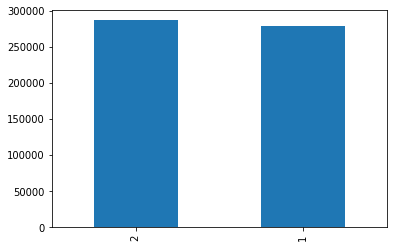

In [14]:
df["sex"].value_counts().plot.bar()
# Docs says that sex == 1 means male, but then some males are pregnant and no females are pregnant. 
# Also, all pregnancy data for sex == 2 is NaN, so it seems that sex should be switched, as opposed to pregnant column.
df.sex = df.sex.replace([1,2], [2, 1])



In [15]:
(df[df['sex'] == 1]['survive'].value_counts()/df[df['sex'] == 1]['survive'].count())*100

0    91.822007
1     8.177993
Name: survive, dtype: float64

In [16]:
(df[df['sex'] == 2]['survive'].value_counts()/df[df['sex'] == 2]['survive'].count())*100

0    95.45744
1     4.54256
Name: survive, dtype: float64

## Age

Text(22.248996913580257, 0.5, 'count')

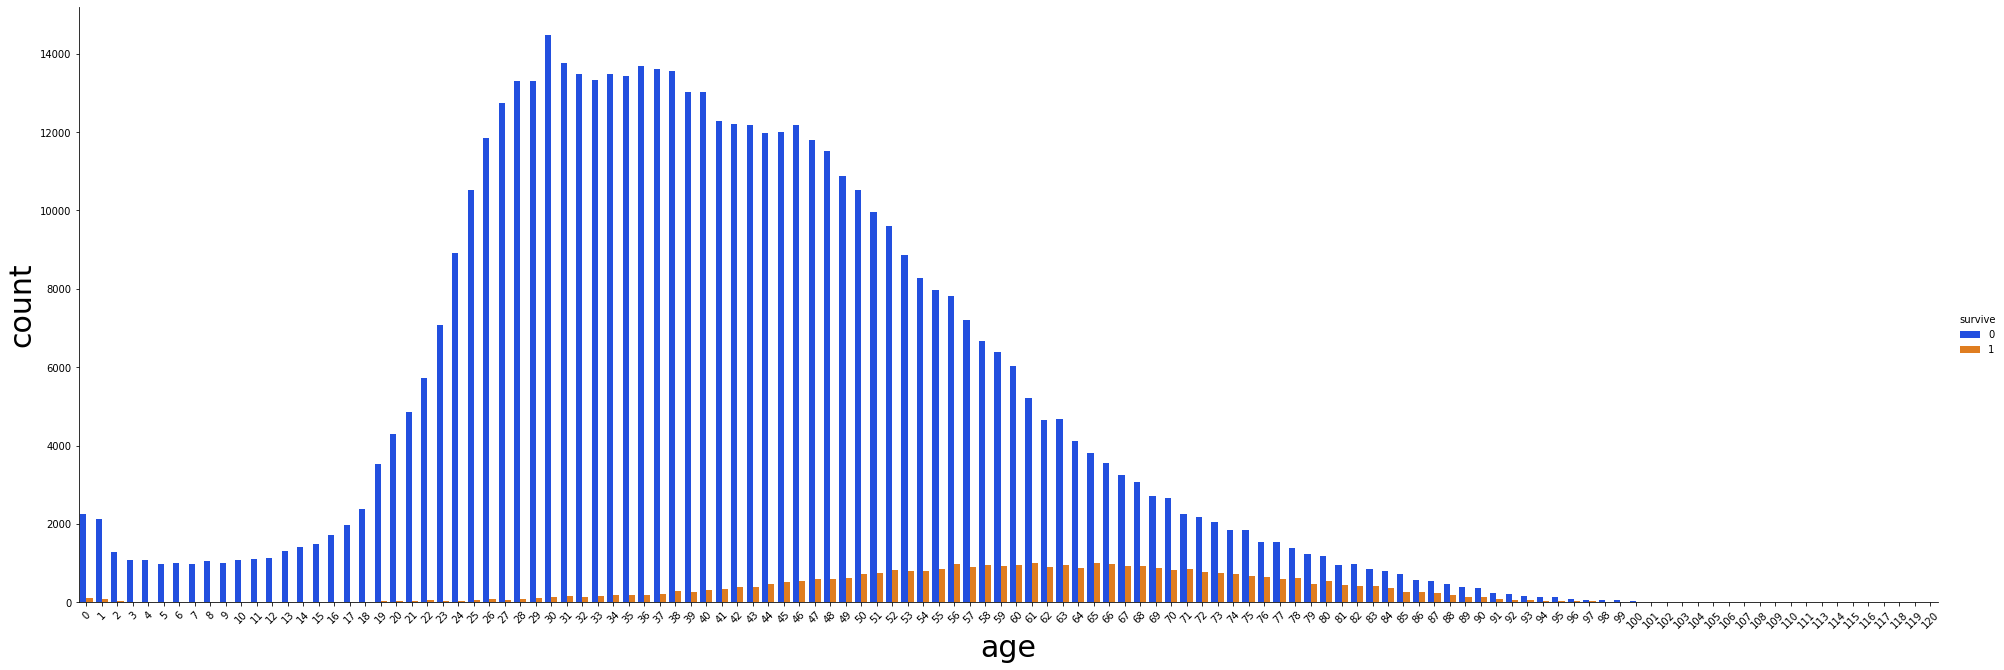

In [17]:
sns.catplot('age',data=df,hue='survive',kind='count',palette='bright',aspect=3,height=9)
plt.xlabel('age',size=30)
plt.xticks(rotation=45)
plt.ylabel('count',size=30)

## Intubed

In [18]:
df["intubed"].replace({97: 2, 99: 2}, inplace=True)

In [19]:
df['intubed'].value_counts().to_frame()

,intubed
2,556637
1,9965


## Pregnancy

In [20]:
df["pregnancy"].replace({97: 2, 98: 2}, inplace=True)

## contact_other_covid

In [21]:
df["contact_other_covid"].replace({99: 3}, inplace=True)

## ICU

In [22]:
# df["icu"].replace({97: 2, 99: 2}, inplace=True)
df=df[df['icu']!=99]
df=df[df['icu']!=97]
# df.info()

## Remove rest missing value row

In [23]:
# df = df[(df.pneumonia != 99)]
df = df[(df.pneumonia != 99) & (df.diabetes != 98) & (df.copd != 98)]
df = df[(df.asthma != 98) & (df.inmsupr != 98) & (df.hypertension != 98)]
df = df[(df.other_disease != 98) & (df.cardiovascular != 98) & (df.obesity != 98)]
df = df[(df.renal_chronic != 98) & (df.tobacco != 98)]

## Drop less important value

In [24]:
df = df.drop(['id', 'entry_date', 'date_symptoms', 'other_disease' , 'icu', 'cardiovascular', 'copd', 'renal_chronic', 'inmsupr', 'asthma', 'pregnancy', 'patient_type'], axis=1)

In [25]:
# for c in df.columns:
#     print ("---- %s ---" % c)
#     print (df[c].value_counts())

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120182 entries, 2 to 566599
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   sex                  120182 non-null  int64
 1   survive              120182 non-null  int32
 2   intubed              120182 non-null  int64
 3   pneumonia            120182 non-null  int64
 4   age                  120182 non-null  int64
 5   diabetes             120182 non-null  int64
 6   hypertension         120182 non-null  int64
 7   obesity              120182 non-null  int64
 8   tobacco              120182 non-null  int64
 9   contact_other_covid  120182 non-null  int64
 10  covid_res            120182 non-null  int64
 11  date_Difference      120182 non-null  int64
dtypes: int32(1), int64(11)
memory usage: 11.5 MB


In [27]:
df.isna().sum() 

sex                    0
survive                0
intubed                0
pneumonia              0
age                    0
diabetes               0
hypertension           0
obesity                0
tobacco                0
contact_other_covid    0
covid_res              0
date_Difference        0
dtype: int64

Text(0.5, 1.0, 'Correlation heatmap')

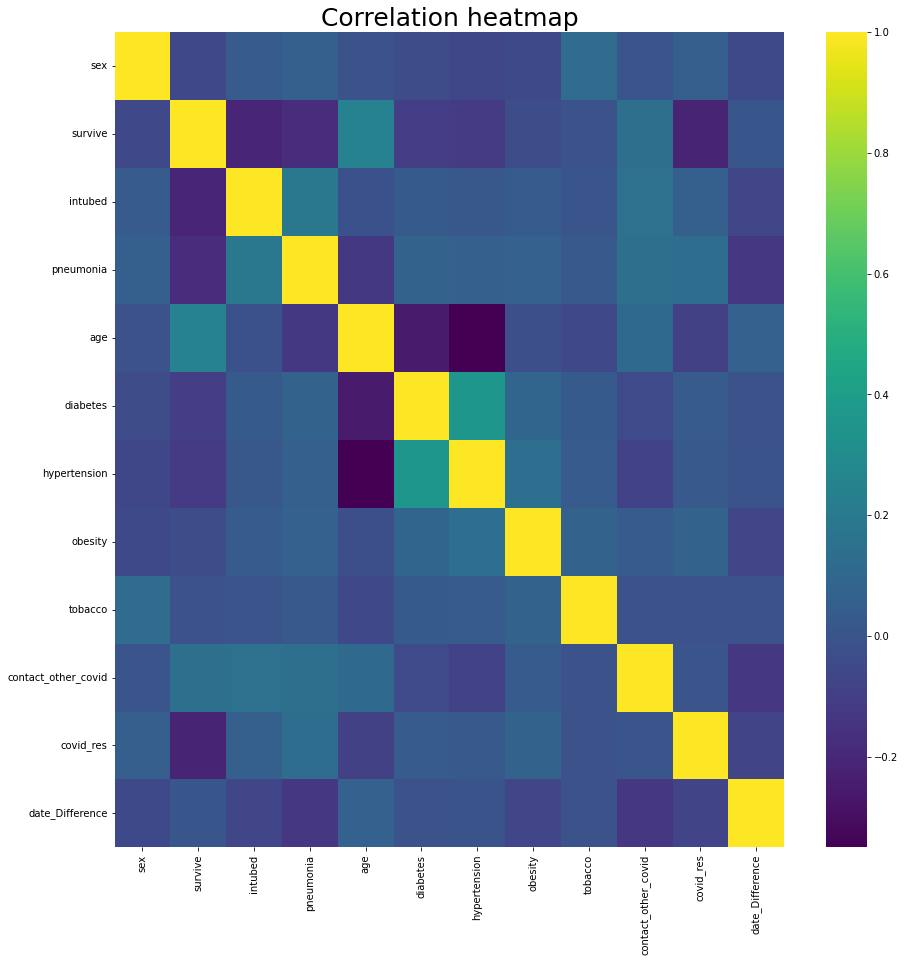

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap='viridis')
plt.title('Correlation heatmap',size=25)

# Training the model using different algorithms

## Data split into train set and test set

In [29]:
y = df['survive']
X = df.drop(['survive'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90136, 11) (30046, 11) (90136,) (30046,)


In [31]:
acc=[]

## Logistic Regression Model

### Train the Model

In [32]:
logreg = LogisticRegression(random_state = 20, class_weight = 'balanced')

In [33]:
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=20)

### Predictions and Evaluation
Now that we have a model, lets take a look at how it performs. 

In [34]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.87      0.68      0.77     66150
           1       0.45      0.73      0.56     23986

    accuracy                           0.69     90136
   macro avg       0.66      0.70      0.66     90136
weighted avg       0.76      0.69      0.71     90136



In [35]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.68      0.77     22051
           1       0.45      0.73      0.56      7995

    accuracy                           0.69     30046
   macro avg       0.66      0.70      0.66     30046
weighted avg       0.76      0.69      0.71     30046



In [36]:
acc.append(0.73)

##  Naive_bayes Model

### Train the Model

In [37]:
gnb = GaussianNB()
gnb.fit(X_train, y_train) 

GaussianNB()

### Predictions and Evaluation

In [38]:
yhat = gnb.predict(X_test)
gnb_score=metrics.accuracy_score(y_test, yhat)
print("GNB's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))

GNB's Accuracy:0.7505158756573255


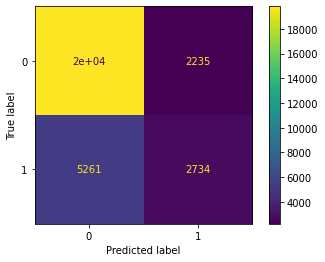

In [39]:
plot_confusion_matrix(gnb, X_test, y_test)

In [40]:
acc.append(0.75)

##  KNN Model

### Train the Model

In [41]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import metrics

# for i in range(1,25):
    
#     neigh=KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
#     yhat = neigh.predict(X_test)
#     KNN_score=metrics.accuracy_score(y_test, yhat)
#     print("Train set Accuracy at {} is {}  ".format(i,metrics.accuracy_score(y_train, neigh.predict(X_train))))
#     print("Test set Accuracy at {} is {}".format(i,KNN_score))
#     print("\n")

Running Result:

Train set Accuracy at 1 is 0.9211524806958374  
Test set Accuracy at 1 is 0.6827198295946216


Train set Accuracy at 2 is 0.8264955178840863  
Test set Accuracy at 2 is 0.7313785528855754


Train set Accuracy at 3 is 0.8343170320404721  
Test set Accuracy at 3 is 0.7132064168275312


Train set Accuracy at 4 is 0.8053607881423627  
Test set Accuracy at 4 is 0.7398988218065633


Train set Accuracy at 5 is 0.8097652436318452  
Test set Accuracy at 5 is 0.7306463422751781


Train set Accuracy at 6 is 0.7947434987130558  
Test set Accuracy at 6 is 0.7419956067363376


Train set Accuracy at 7 is 0.7957974616135617  
Test set Accuracy at 7 is 0.7375357784730081


Train set Accuracy at 8 is 0.786644625898642  
Test set Accuracy at 8 is 0.7449577314783998


Train set Accuracy at 9 is 0.7887969290849384  
Test set Accuracy at 9 is 0.7446249084736737


Train set Accuracy at 10 is 0.7830833407295642  
Test set Accuracy at 10 is 0.7494175597417293


Train set Accuracy at 11 is 0.7846254548681991  
Test set Accuracy at 11 is 0.7463888703987219


Train set Accuracy at 12 is 0.7795553385994497  
Test set Accuracy at 12 is 0.7506822871596884


Train set Accuracy at 13 is 0.7810974527380846  
Test set Accuracy at 13 is 0.7510151101644146


Train set Accuracy at 14 is 0.7762381290494365  
Test set Accuracy at 14 is 0.753111895094189


Train set Accuracy at 15 is 0.7788563947812195  
Test set Accuracy at 15 is 0.7522798375823737


Train set Accuracy at 16 is 0.7742411467116358  
Test set Accuracy at 16 is 0.752845636690408


Train set Accuracy at 17 is 0.7769370728676667  
Test set Accuracy at 17 is 0.7514144977700858


Train set Accuracy at 18 is 0.7728543534214964  
Test set Accuracy at 18 is 0.7531451773946615


Train set Accuracy at 19 is 0.7748402414129759  
Test set Accuracy at 19 is 0.7531784596951341


Train set Accuracy at 20 is 0.7713233336291826  
Test set Accuracy at 20 is 0.7537109765026959


Train set Accuracy at 21 is 0.7732648442353777  
Test set Accuracy at 21 is 0.7524462490847368


Train set Accuracy at 22 is 0.770391408538209  
Test set Accuracy at 22 is 0.7525460959861545


Train set Accuracy at 23 is 0.7719113339842016  
Test set Accuracy at 23 is 0.7536776942022233


Train set Accuracy at 24 is 0.7697479364515842  
Test set Accuracy at 24 is 0.752845636690408

### Predictions and Evaluation

at n_neighbours=12 we are getting max train and test accuracy i.e, 78% and 75% respectively.

In [42]:
acc.append(0.75)

##  Decision Tree model

### Train the Model

In [43]:
dt = DecisionTreeClassifier()
#min_sample_leaf, the most common stopping procedure is to use a minimum count on the number on the number of training instances assigned to each leaf node.
dt.fit(X_train, y_train)

DecisionTreeClassifier()

### Predictions and Evaluation

In [44]:
y_pred = dt.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [45]:
dt_score = accuracy_score(y_test, y_pred)
print("Accuracy: {0}".format(dt_score))

Accuracy: 0.7078146841509685


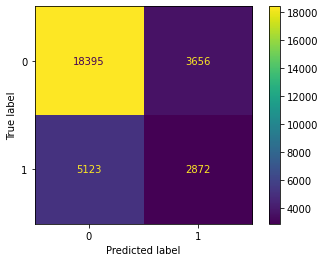

In [46]:
plot_confusion_matrix(dt, X_test, y_test)

In [47]:
acc.append(0.71)

### Feature Importances

In [48]:
# let's create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, dt.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [49]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

In [50]:
feat_df

,Feature,Importance
0,age,0.326472
1,date_Difference,0.210370
2,covid_res,0.080466
3,contact_other_covid,0.062026
4,intubed,0.053910
5,obesity,0.052348
6,hypertension,0.047543
7,sex,0.045684
8,diabetes,0.044974
9,pneumonia,0.042069


##  SVM

### Train the Model

Running cost 10 mins, record result below

In [51]:
# from sklearn import svm
# supvm = svm.SVC(kernel='rbf')
# supvm.fit(X_train, y_train) 

### Predictions and Evaluation

In [52]:
# yhat = supvm.predict(X_test)
# svm_score=metrics.accuracy_score(y_test, yhat)
# print("SVM's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))

Result: SVM's Accuracy:0.741962324435865

In [53]:
acc.append(0.74)

## Random Forest Classifier

### Train the Model

In [54]:
from sklearn.ensemble import RandomForestClassifier
Random_forest = RandomForestClassifier(n_estimators=50)
Random_forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

### Predictions and Evaluation

In [55]:
randomForest_predict = Random_forest.predict(X_test)
randomForest_score = metrics.accuracy_score(y_test, randomForest_predict)
print("Random Forest Score :",randomForest_score)

Random Forest Score : 0.7258204087066498


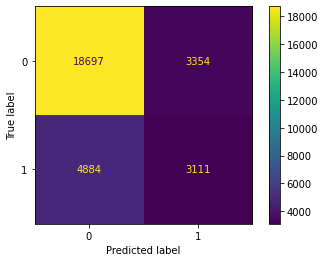

In [56]:
plot_confusion_matrix(Random_forest, X_test, y_test)

In [57]:
acc.append(0.73)

## Gradient Boosting

### Train the Model

In [58]:
gbk = GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)
gbk.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, min_samples_split=100, n_estimators=150,
                           random_state=100)

### Predictions and Evaluation

In [59]:
gbk_predict = gbk.predict(X_test)
gbk_score = gbk.score(X_test,y_test)
#print("Gradient Boosting Prediction :",gbk_predict)
print("Gradient Boosting Score :",gbk_score)

Gradient Boosting Score : 0.7735805098848433


<Figure size 1440x1440 with 0 Axes>

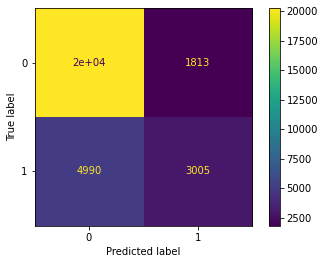

In [60]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(gbk, X_test, y_test)

In [61]:
acc.append(0.77)

# Conclusion

In [62]:
acc

[0.73, 0.75, 0.75, 0.71, 0.74, 0.73, 0.77]

In [63]:
algo_name = ['Logistic Regression','Naive Bayes','KNN','Decision Tree','SVM','Random Forest','Gradient Boosting']
acc=np.array(acc)

In [64]:
result = pd.DataFrame(list(zip(acc, algo_name)),columns =['acc', 'algo_name'])

In [65]:
result

,acc,algo_name
0,0.73,Logistic Regression
1,0.75,Naive Bayes
2,0.75,KNN
3,0.71,Decision Tree
4,0.74,SVM
5,0.73,Random Forest
6,0.77,Gradient Boosting


In [66]:
result.sort_values('acc')

,acc,algo_name
3,0.71,Decision Tree
0,0.73,Logistic Regression
5,0.73,Random Forest
4,0.74,SVM
1,0.75,Naive Bayes
2,0.75,KNN
6,0.77,Gradient Boosting


Text(0, 0.5, 'Algorithm Name')

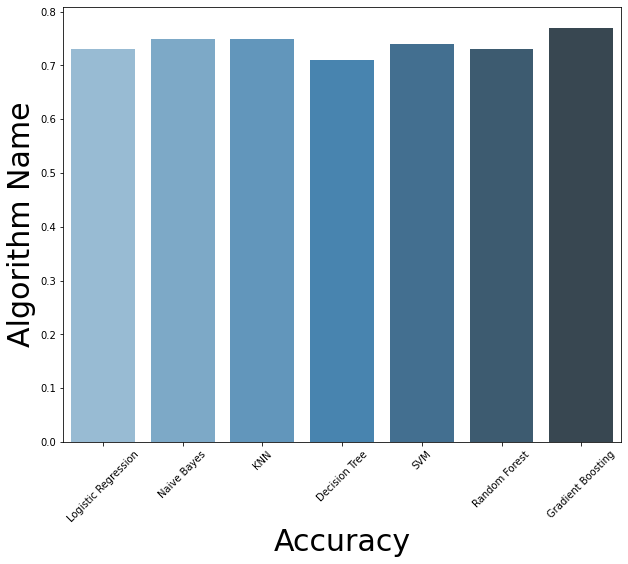

In [67]:
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y='acc', x='algo_name', estimator=median,palette="Blues_d", data = result)
plt.xlabel('Accuracy',size=30)
plt.xticks(rotation=45)
plt.ylabel('Algorithm Name',size=30)

# sns.barplot(x = 'class', y = 'fare', hue = 'sex', data = df)

From different models, we can conclude that Gradient Boosting provide better accuracy among these models. Accuracy is 0.77.

# Future work

1. With bigger dataset and more features included, we would be able to generate a better model with higher accuracy.
2. As the vaccination been given to the population, we may able to trace the efficiency along the time and also reply it to different group of people.
3. Some model really cost long time to have result, I want to adjust it or find better mathine learning model to fit the columns. 